# Netflix Churn Analysis 

How good is our model? Well we need to express, test, and cycle. So a constant upgrading of what we're doing and data we're using is necessary. but remember is the new version of our data better than the last?

Let's use cross validation to test this out.

This attempts to avoid over fitting )training on and predicting the same datapoints) while still producing a prediction for each observation dataset. So you hide subsets in the data while training a set of models.

After training each model predicts on the subset that has been hidden to it, emulating multipule train-test splits. When done correctly, every observation will have a 'fair' corresponding prediction.

Let's use scikit-learn!

This is a replication of (http://nbviewer.ipython.org/github/donnemartin/data-science-ipython-notebooks/blob/master/analyses/churn.ipynb) inorder to learn how to create some data analysis tools as well as learn iPython notebook.

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline 

In [2]:
churn_df = pd.read_csv('churn_data.csv')
col_names = churn_df.columns.tolist()

# This just shows the names of the columsn you have to choose from
print "Column names:"
print col_names

# Only taking some of the column names
to_show = col_names[:6] + col_names[-6:]

print "\nSample data:"
churn_df[to_show].head(6)

print "\Data Shape: there are %d rows and %d columns" % churn_df.shape

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:
\Data Shape: there are 3333 rows and 21 columns


Rember ML code does not pick up on 'yes' and 'no' very well, so we'll need to change those values into something readable. 

In [3]:
# Isolate target data
churn_result = churn_df['Churn?']

# np.where() = Return elements, either from x or y, depending on condition.
# if 'True' = 1, if not 'True' = 0
y = np.where(churn_result == 'True.',1,0)

In [4]:
# We don't need all the columns so let's drop a lot of them
to_drop = ['State', 'Area Code', 'Phone', 'Churn?']
churn_feat_space = churn_df.drop(to_drop, axis = 1)

print churn_feat_space.head()

   Account Length Int'l Plan VMail Plan  VMail Message  Day Mins  Day Calls  \
0             128         no        yes             25     265.1        110   
1             107         no        yes             26     161.6        123   
2             137         no         no              0     243.4        114   
3              84        yes         no              0     299.4         71   
4              75        yes         no              0     166.7        113   

   Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  Night Calls  \
0       45.07     197.4         99       16.78       244.7           91   
1       27.47     195.5        103       16.62       254.4          103   
2       41.38     121.2        110       10.30       162.6          104   
3       50.90      61.9         88        5.26       196.9           89   
4       28.34     148.3        122       12.61       186.9          121   

   Night Charge  Intl Mins  Intl Calls  Intl Charge  CustServ Calls  
0   

In [5]:
# Just as above 'yes' / 'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. ... later

yes_no_cols = ['Int\'l Plan','VMail Plan']
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'
print churn_feat_space.head()

   Account Length Int'l Plan VMail Plan  VMail Message  Day Mins  Day Calls  \
0             128      False       True             25     265.1        110   
1             107      False       True             26     161.6        123   
2             137      False      False              0     243.4        114   
3              84       True      False              0     299.4         71   
4              75       True      False              0     166.7        113   

   Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  Night Calls  \
0       45.07     197.4         99       16.78       244.7           91   
1       27.47     195.5        103       16.62       254.4          103   
2       41.38     121.2        110       10.30       162.6          104   
3       50.90      61.9         88        5.26       196.9           89   
4       28.34     148.3        122       12.61       186.9          121   

   Night Charge  Intl Mins  Intl Calls  Intl Charge  CustServ Calls  
0   

In [6]:
# Pull out features for future use
features = churn_feat_space.columns
print features

Index([u'Account Length', u'Int'l Plan', u'VMail Plan', u'VMail Message',
       u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls',
       u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge',
       u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls'],
      dtype='object')


In [7]:
X = churn_feat_space.as_matrix().astype(np.float)

# This is important so pay attention

# Standardization of a dataset is a common requirement for many 
# machine learning estimators: they might behave badly if the 
# individual feature do not more or less look like standard normally 
# distributed data (e.g. Gaussian with 0 mean and unit variance).

# StandardScaler fixes this by normalizing each feature to a range 
# of around 1.0 to -1.0 thereby preventing models from misbehaving
scaler = StandardScaler()

# fit_transform() --> Learn a list of feature name, 
# indices mappings and transform X.
# Like fit(X) followed by transform(X), but does not require 
# materializing X in memory.
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


In [8]:
# K-Folds cross validation iterator.
# Provides train/test indices to split data in 
# train test sets. Split dataset into k consecutive
# folds (without shuffling by default).

from sklearn.cross_validation import KFold

def run_cv(X, y, clf_class, **kwargs):
    # Construct a kfolds object
    kf = KFold(len(y), n_folds=3, shuffle=True)
    y_pred = y.copy()
    
    # Iterrate through the folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initalize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        
        # Remember: first you train, then you fit, then you predict
        y_pred[test_index] = clf.predict(X_test)
        
        return y_pred

Lets look at these fairly unique algorithms support vector machines (SVM), random forests (RF), neighbors, linear modeling / regeress, and gradient boosting classification (GBC).

Let's just take a look at when the classifier predicted the correct class.

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true, y_pred):
    #NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Logisitc Regression:"
print "%.3f" % accuracy(y, run_cv(X, y, LR))

print "Gradient Boosting Classifier:"
print "%.3f" % accuracy(y, run_cv(X, y, GBC))

print "Support Vector Machines:"
print "%.3f" % accuracy(y, run_cv(X, y, SVC))

print "Random Forest:"
print "%.3f" % accuracy(y, run_cv(X, y, RF))

print "k-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X, y, KNN))

Logisitc Regression:
0.957
Gradient Boosting Classifier:
0.984
Support Vector Machines:
0.976
Random Forest:
0.977
k-nearest-neighbors:
0.959


Does the highest number mean the best? We'll see.

Remember the output will change after every iteration of the models.

The problem with out comes aren;t necessarily equal. If my classifier predicted a customer would churn and they didn't, that's not the best but it's forgivable. However, if my classifier predicted a customer would return, I didn't act, and then they churned ... that's really bad.

|condition True|condition False|
-|-|-
prediction true|True Positive (TP)|False positive (FP)
prediction False|False Negative (FN)|True Negative (TN)

Sensitivity, __Recall__ or True Positive Rate (TPR) quantify the models ability to predict our positive classes. 

$$TPR = TP / (TP + FN)$$

Specificity, __precision__ or True Negative Rate (TNR) quantify the models ability to predict our Negative classes.

$$TNR = TN / (TN + FP)$$

Here is an example:

|Apple|Orange|
-|-|-
prediction Apple|400|250
prediction Orange|230|40

$$TPR = TP / (TP + FN) = 400 / (400+230) = 63.49Sensitive$$

$$TNR = TN / (TN + FP) = 40 / (40 + 250) = 13.79Specific$$

Now that we know what the confusion matrix does in theory, let's put this into application and get some stuff done!

 [[2837   13]
 [  69  414]]

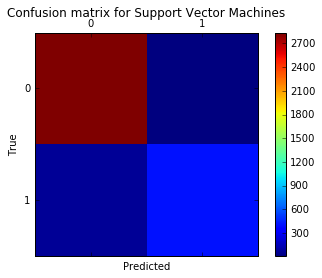

 [[2845    5]
 [  68  415]]

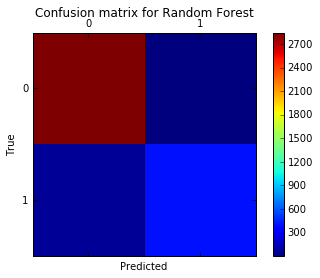

 [[2835   15]
 [ 102  381]]

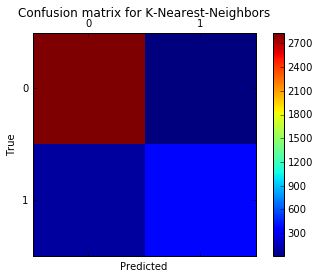

 [[2837   13]
 [  49  434]]

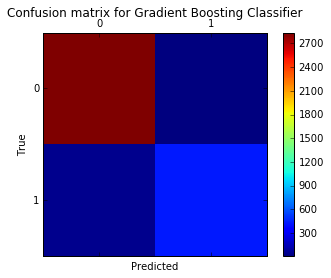

 [[2823   27]
 [ 127  356]]

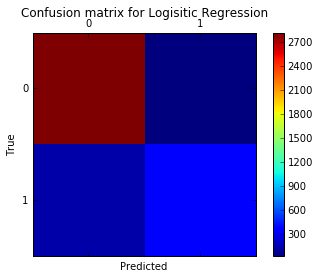

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def draw_confusion_matrices(confusion_matricies, class_names):
    # tolist() takes an array and puts the elements into a list
    class_names = class_names.tolist()
    
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print (cm)
        # print recall_score(cm[0], cm[1])
        # print precision_score((cm[0], cm[1]))
        
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # matshow() is essentailly a heatmap
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y, run_cv(X, y, SVC)) ),
    ( "Random Forest", confusion_matrix(y, run_cv(X, y, RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y, run_cv(X, y, KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y, run_cv(X, y, GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y, run_cv(X, y, LR)) )
]

# Pyplot code not included to reduce clutter
# from chrun_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

In [28]:
# Figure out how to cut code that returns the precision_score and recall_score

An important question might be: when someone 'churns' how often is my classifier correct?

Another one is how "precise" is my classifier? Or how often does that person acutally churn?

What is an ROC plot? It is a receiver operating characteristic. It is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is caried.

It is mapped by plotting the true positive rate against the false positive rate.

Support vector machines:


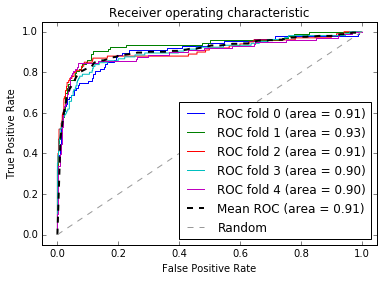

Random forests:


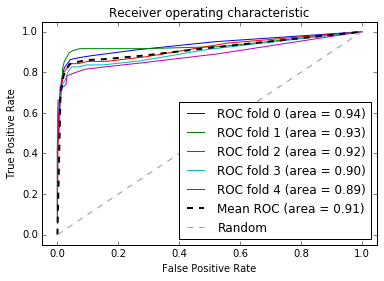

K-nearest-neighbors:


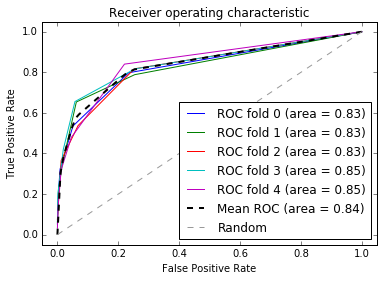

Gradient Boosting Classifier:


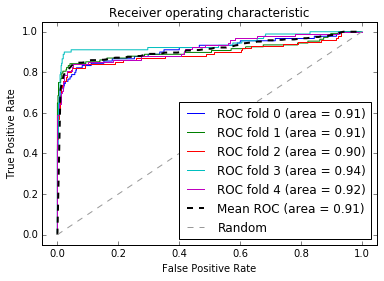

In [33]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, ** kwargs):
    # K Fold Cross-validation is used to generalize to an independent
    # dataset. It is mainly used in settings where the goal is prediction,
    # and one wants to estimate how accurately a predictive model
    # will perform in practice
    kf = KFold(len(y), n_folds = 5, shuffle = True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    # This is the diag line down the center of the grid
    plt.plot([0, 1], [0, 1],'--', color=(0.6, 0.6, 0.6), label = 'Random')
    
    # Remember there are n_folds = 5, there there will be 0 - 4 ROC folds
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

print "Support vector machines:"
plot_roc(X,y,SVC,probability=True)

print "Random forests:"
plot_roc(X,y,RF,n_estimators=18)

print "K-nearest-neighbors:"
plot_roc(X,y,KNN)

print "Gradient Boosting Classifier:"
plot_roc(X,y,GBC)
    

Now that we understand the accuracy of each individual model lets dice a little deeper to get a better understanding of what features or behaviors are causing our customers to churn.

We're going to use RandomForestClassifier to build decision trees to predict churn.

First step is to build the decision tree to calculate the information gain.

Let's look at the Top 1- features in our dataset that contribute to customer churn.

Feature ranking:
1. Account Length (0.163057)
2. Int'l Plan (0.143775)
3. VMail Plan (0.074115)
4. VMail Message (0.071675)
5. Day Mins (0.064395)
6. Day Calls (0.039133)
7. Day Charge (0.029995)
8. Eve Mins (0.026002)
9. Eve Calls (0.024487)
10. Eve Charge (0.016137)


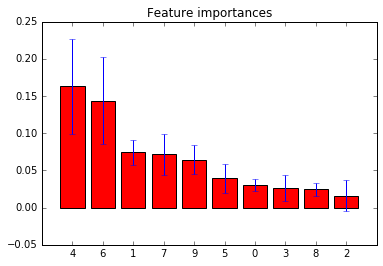

In [41]:
train_index, test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
# import pylab as pl

plt.figure()
plt.title("Feature importances")
# yerr --> the y error of the graph
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

Now we need to think is probabilities.

To think of a customer as expected value of churn, we can gague their value and expected loss.

E.g. Do you want edo reach out to a customer with an 80% churn risk who pays $20,000 annually or the client who is worth $100K with a 40% churn risk? How much should you spend on each client?

This is different from ML ...you need to produce a prediction.

In [42]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        # The CLF is the estimator that is then fitted to the model.
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        
        # Predict probabilities, not classes
        # predict_proba() --> svm_model stores all parameters needed to predict a given value.
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

If I predict there's a 20% likelihood of x occuring tomorrow I don't get to live out all the possible outcomes of the universe. It either happens or it doesn't.

So new we need to use pandas to compare the predictions made by the random forest against the actual outcomes.

In [43]:
import warnings
# Adding a warning
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]

0.0    1755
0.1     720
0.2     251
0.3     121
0.5      81
0.4      80
0.8      71
0.7      69
0.9      65
0.6      64
1.0      56
dtype: int64

In [44]:
from collections import defaultdict
# Returns a new dictionary-like object

true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1755,0.027350
1,0.1,720,0.031944
2,0.2,251,0.051793
3,0.3,121,0.132231
4,0.4,80,0.412500
5,0.5,81,0.629630
6,0.6,64,0.750000
7,0.7,69,0.869565
8,0.8,71,0.985915
9,0.9,65,1.000000


From this we can see we predicted a churn probability of 90% but the actual churn was 100%.
While for 80% the actual churn was 98%